# Importing Dependecies


In [9]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization,Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import os
import re
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image 

In [10]:
from keras import backend as K


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [3]:
PATH = "/content/drive/MyDrive/minor_gans/new_chest_xray"
METRICS_PATH="/content/drive/MyDrive/minor_gans/output/GoogleNet/"
MODEL_NAME="GoogleNetGans"
print("PWD", PATH)

PWD /content/drive/MyDrive/minor_gans/new_chest_xray


# Define Metrics

In [4]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [5]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [7]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [11]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['NORMAL', 'PNEUMONIA']


In [12]:
img_data_list = []

for dataset in data_dir_list:
    count=0
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        count+=1
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-NORMAL

Loaded the images of dataset-PNEUMONIA



In [13]:

img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(7856, 1, 32, 32, 3)
(1, 7856, 32, 32, 3)
(7856, 32, 32, 3)


# Train & Test Data

In [14]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:1584] = 0
labels[1584:] = 1
names = ['NORMAL', 'PNEUMONIA']

sample 7856


In [15]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [16]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [18]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/minor_gans/output/GoogleNet/GoogleNetGans.csv


In [19]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

In [20]:
batch_size = 16
data_augmentation = False
epochs = 100

In [21]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Not using data augmentation.
Epoch 1/100
393/393 [==============================] - 17s 16ms/step - loss: 0.2295 - accuracy: 0.9093 - f1: 0.9092 - specificity: 0.9092 - sensitivity: 0.9092 - val_loss: 1.6376 - val_accuracy: 0.8041 - val_f1: 0.8056 - val_specificity: 0.8056 - val_sensitivity: 0.8056 - lr: 0.0010
Epoch 2/100
393/393 [==============================] - 5s 12ms/step - loss: 0.1535 - accuracy: 0.9426 - f1: 0.9425 - specificity: 0.9425 - sensitivity: 0.9425 - val_loss: 0.1075 - val_accuracy: 0.9644 - val_f1: 0.9646 - val_specificity: 0.9646 - val_sensitivity: 0.9646 - lr: 0.0010
Epoch 3/100
393/393 [==============================] - 4s 10ms/step - loss: 0.1150 - accuracy: 0.9585 - f1: 0.9584 - specificity: 0.9584 - sensitivity: 0.9584 - val_loss: 0.1302 - val_accuracy: 0.9561 - val_f1: 0.9564 - val_specificity: 0.9564 - val_sensitivity: 0.9564 - lr: 0.0010
Epoch 4/100
393/393 [==============================] - 3s 9ms/step - loss: 0.1006 - accuracy: 0.9604 - f1: 0.9603 - speci

# Results

In [22]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 477.481059551239
50/50 [==============================] - 1s 5ms/step - loss: 0.1602 - accuracy: 0.9771 - f1: 0.9775 - specificity: 0.9775 - sensitivity: 0.9775
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.22952893376350403, 0.1534629911184311, 0.11504446715116501, 0.1006312295794487, 0.09316416084766388, 0.08958880603313446, 0.07858826220035553, 0.06996361911296844, 0.06577102094888687, 0.031746093183755875, 0.017218219116330147, 0.009732004255056381, 0.005281358025968075, 0.005395990796387196, 0.005719870328903198, 0.003735474543645978, 0.0009698107605800033, 0.0010763028403744102, 0.000743559910915792, 0.00035650847712531686, 0.00024175335420295596, 0.00017814461898524314, 0.00020172828226350248, 0.00013506421237252653, 0.0001422682689735666, 0.00013065164966974407, 0.00012493965914472938, 8.85690315044485e-05, 0.00010859976

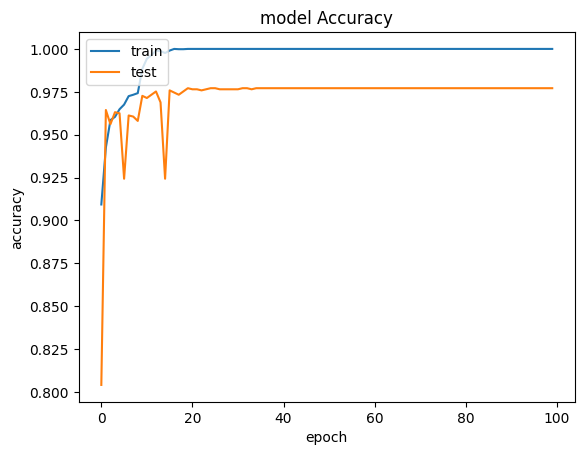

In [23]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


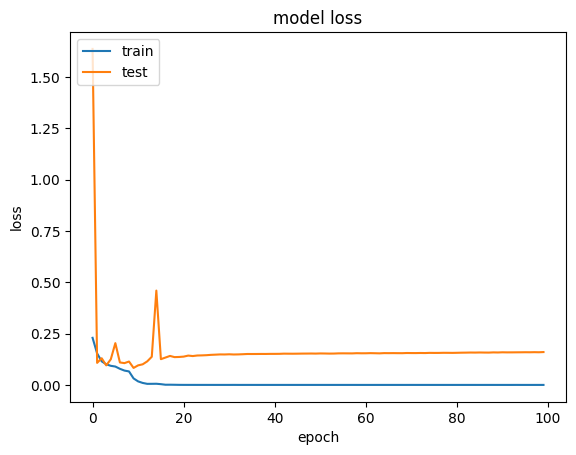

In [24]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


# with aug

In [ ]:
MODEL_NAME="GoogleNet_aug"

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 64)  0           ['conv2d_18[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 64)  256         ['max_pooling2d_6[0][0]']        
 rmalization)                                                                               

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/minor_gans/output/GoogleNet/GoogleNet_aug.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet_aug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Using real-time data augmentation.
Epoch 1/100


<ipython-input-30-1769102c3309>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


293/293 [==============================] - 8s 20ms/step - loss: 0.3173 - accuracy: 0.8681 - f1: 0.8682 - specificity: 0.8682 - sensitivity: 0.8682 - val_loss: 1.3734 - val_accuracy: 0.7321 - val_f1: 0.7312 - val_specificity: 0.7312 - val_sensitivity: 0.7312 - lr: 0.0010
Epoch 2/100
293/293 [==============================] - 4s 15ms/step - loss: 0.2597 - accuracy: 0.8909 - f1: 0.8909 - specificity: 0.8909 - sensitivity: 0.8909 - val_loss: 0.2639 - val_accuracy: 0.9036 - val_f1: 0.9046 - val_specificity: 0.9046 - val_sensitivity: 0.9046 - lr: 0.0010
Epoch 3/100
293/293 [==============================] - 8s 28ms/step - loss: 0.2280 - accuracy: 0.9086 - f1: 0.9087 - specificity: 0.9087 - sensitivity: 0.9087 - val_loss: 0.4896 - val_accuracy: 0.7824 - val_f1: 0.7811 - val_specificity: 0.7811 - val_sensitivity: 0.7811 - lr: 0.0010
Epoch 4/100
293/293 [==============================] - 4s 14ms/step - loss: 0.2222 - accuracy: 0.9140 - f1: 0.9140 - specificity: 0.9140 - sensitivity: 0.9140 - va

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 747.6301980018616
37/37 [==============================] - 0s 8ms/step - loss: 0.1076 - accuracy: 0.9650 - f1: 0.9654 - specificity: 0.9654 - sensitivity: 0.9654
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.3173431158065796, 0.2597152888774872, 0.22802536189556122, 0.22218509018421173, 0.2035318911075592, 0.19173209369182587, 0.20461058616638184, 0.19272656738758087, 0.19047507643699646, 0.17542150616645813, 0.17985156178474426, 0.17163562774658203, 0.16272424161434174, 0.17553821206092834, 0.1636366844177246, 0.16409912705421448, 0.14881308376789093, 0.1305152177810669, 0.12298065423965454, 0.11671387404203415, 0.13277675211429596, 0.1183614432811737, 0.12124966830015182, 0.11989473551511765, 0.11531475931406021, 0.11822487413883209, 0.10944762825965881, 0.11147727072238922, 0.111648790538311, 0.11106191575527191, 0.1059703528

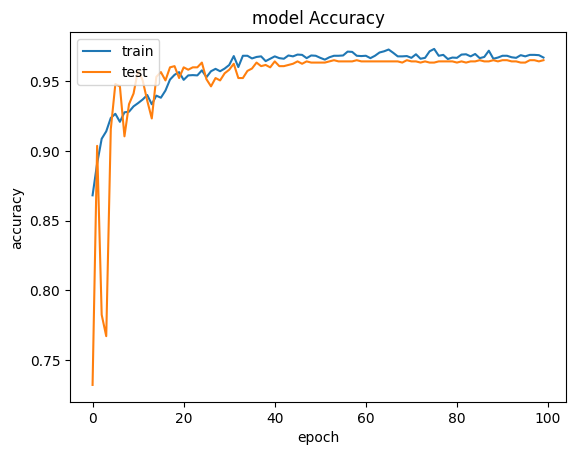

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


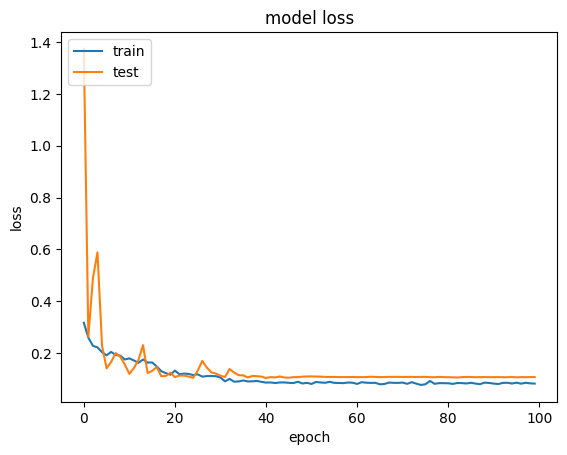

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
